In [1]:
# import result data
import os
import csv

RESULT_PATH = 'results/08-06-2023_04hh_56mm/'
AWS_IP_RANGES_PATH = '/Users/abdullah/Documents/PrimeVideo/PrimeVideo Scripts/aws-ip-ranges.json'

myimage_csv = "results/08-06-2023_04hh_56mm/myimage_08-06-2023_04hh_56mm.csv"
myvideo_csv = "results/08-06-2023_04hh_56mm/myvideo_08-06-2023_04hh_56mm.csv"

ringsofpower_vid_csv = "results/08-06-2023_04hh_56mm/ringsofpower_08-06-2023_04hh_56mm.csv"
citadel_csv = "results/08-06-2023_04hh_56mm/citadel_08-06-2023_04hh_56mm.csv"

samaritan_csv = "results/08-06-2023_04hh_56mm/samaritan_08-06-2023_04hh_56mm.csv"
godzilla_csv = "results/08-06-2023_04hh_56mm/godzilla_08-06-2023_04hh_56mm.csv"

harlem_csv = "results/08-06-2023_04hh_56mm/harlem_08-06-2023_04hh_56mm.csv"
marmaduke_csv = "results/08-06-2023_04hh_56mm/marmaduke_08-06-2023_04hh_56mm.csv"


def read_column_from_csv(file_path, column_name):
    column_values = []
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            column_values.append(row[column_name])
    return column_values

def read_columns_from_multiple_csv_files(directory_path, column_name):
    all_column_values = {}
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)
            column_values = read_column_from_csv(file_path, column_name)
            all_column_values[file_name] = column_values
    return all_column_values

def get_all_column_values(column_name):
    directory_path = RESULT_PATH
    #column_name = 'latency(ms)'
    all_column_values = read_columns_from_multiple_csv_files(directory_path, column_name)
    #print(all_column_values)
    for i, column_values in all_column_values.items():
        pass
        #print(f'"{i}"')
        #print(i, column_values[:5])
    return all_column_values


In [2]:
### Functions to map IP to AWS related data

import json
import ipaddress

# reads AWS ip ranges from json publicly avaialble
def get_aws_ip_ranges():
    # Open the JSON file
    with open(AWS_IP_RANGES_PATH, 'r') as file:
        # Load the JSON data into a dictionary
        data = json.load(file)
        return data["prefixes"]

def map_ip_to_aws(ip_address, ranges_data_list):
    matching_aws_data = None
    
    try:
        ip = ipaddress.ip_address(ip_address)
    except Exception as e:
        print(ip_address, e)
        return matching_aws_data
    
    longest_prefix = -1
    matching_service = ""
    for range_data in ranges_data_list:
        subnet = range_data["ip_prefix"]
        network = ipaddress.ip_network(subnet)
        service = range_data["service"]
        region = range_data["region"]
        if ip in network and network.prefixlen >= longest_prefix:
            if service == "AMAZON" and matching_service != "AMAZON" and matching_service != "":
                continue
            matching_aws_data = range_data
            matching_service = service
            longest_prefix = network.prefixlen

    return matching_aws_data


# for testing
#responseIP = "18.165.185.120"
responseIP = "18.165.185.129"
subnet_list = get_aws_ip_ranges()
aws_data = map_ip_to_aws(responseIP, subnet_list)
print(responseIP,"\n",aws_data)

18.165.185.129 
 {'ip_prefix': '18.164.0.0/15', 'region': 'GLOBAL', 'service': 'CLOUDFRONT', 'network_border_group': 'GLOBAL'}


In [ ]:
### Add AWS Service info in the CSV files

import pandas as pd

ip_to_aws = {} # storing to avoid longest prefix match call to function

# Reads a column containing IPs from a csv and maps the IPs to AWS data
def get_ip_to_aws_data(dataname, ip_column, csv_filename):
    file_path = f"{RESULT_PATH}/{csv_filename}"
    ips = read_column_from_csv(file_path, ip_column)
    ranges_list = get_aws_ip_ranges()

    service_list = []
    
    for ip in ips:
        if ip in ip_to_aws:
            aws_data = ip_to_aws[ip]
        else:
            aws_data = map_ip_to_aws(ip, ranges_list)
        
        if aws_data:
            aws_service = aws_data[dataname]
        else:
            aws_service = ""
        
        service_list.append(aws_service)
        ip_to_aws[ip] = aws_data
        print(ip_column, ":", ip, aws_service, csv_filename)
        #break
    
    return service_list

# Adds AWS related info for the resonseIP and X-Server-IP in the CSV file
def add_aws_data(csv_filename):
    resp_ip_service = get_ip_to_aws_data("service", "responseIP", csv_filename)
    resp_ip_region = get_ip_to_aws_data("region", "responseIP", csv_filename)
    resp_ip_prefix = get_ip_to_aws_data("ip_prefix", "responseIP", csv_filename)
    
    X_Server_IP_service = get_ip_to_aws_data("service", "X-Server-IP", csv_filename)
    X_Server_IP_region = get_ip_to_aws_data("region", "X-Server-IP", csv_filename)
    X_Server_IP_prefix = get_ip_to_aws_data("ip_prefix", "X-Server-IP", csv_filename)

    # Read the CSV file
    df = pd.read_csv(f'{RESULT_PATH}/{csv_filename}')

    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 1
    # Insert the new column at the specified position with data
    if 'responseIP_service' not in df.columns:
        df.insert(insert_position, 'responseIP_service', resp_ip_service)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 2
    # Insert the new column at the specified position with data
    if 'responseIP_region' not in df.columns:
        df.insert(insert_position, 'responseIP_region', resp_ip_region)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 3
    # Insert the new column at the specified position with data
    if 'responseIP_region' not in df.columns:
        df.insert(insert_position, 'responseIP_prefix', resp_ip_prefix)

        
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 1
    # Insert the new column at the specified position with data
    if 'X-Server-IP_service' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_service', X_Server_IP_service)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 2
    # Insert the new column at the specified position with data
    if 'X-Server-IP_region' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_region', X_Server_IP_region)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 3
    # Insert the new column at the specified position with data
    if 'X-Server-IP_region' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_prefix', X_Server_IP_prefix)

    # Save the modified data back to the CSV file
    df.to_csv(f'{RESULT_PATH}/{csv_filename}', index=False)

# go through all csv result file and add in the aws service info
for file_name in os.listdir(RESULT_PATH):
    if file_name.endswith('.csv'):
        print(file_name)
        add_aws_data(file_name)
        '''
        # for testing, only add aws info in this file
        if "samaritan" in file_name:
            add_aws_data(file_name)
        '''

*** Avg latency ***
marmaduke :	 40.04 ms	  90% CI: [38.27, 41.81]
citadel :	 5.86 ms	  90% CI: [5.84, 5.88]
ringsofpower :	 5.84 ms	  90% CI: [5.82, 5.86]
samaritan :	 11.18 ms	  90% CI: [11.16, 11.2]
myimage :	 8.36 ms	  90% CI: [8.31, 8.41]
myvideo :	 5.86 ms	  90% CI: [5.84, 5.88]
godzilla :	 40.25 ms	  90% CI: [38.48, 42.02]
harlem :	 40.3 ms	  90% CI: [38.52, 42.08]


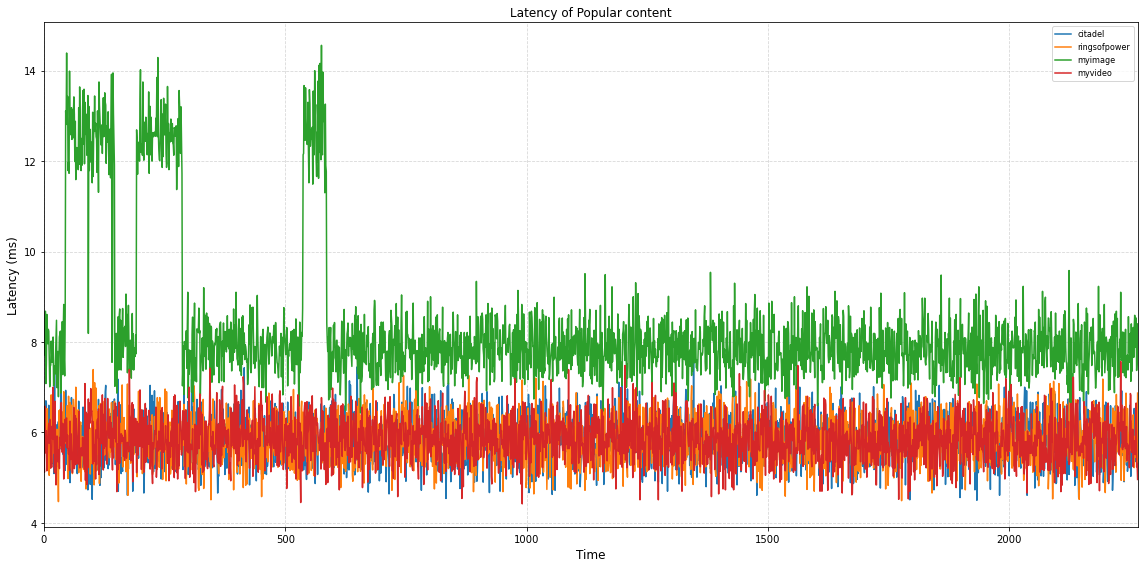

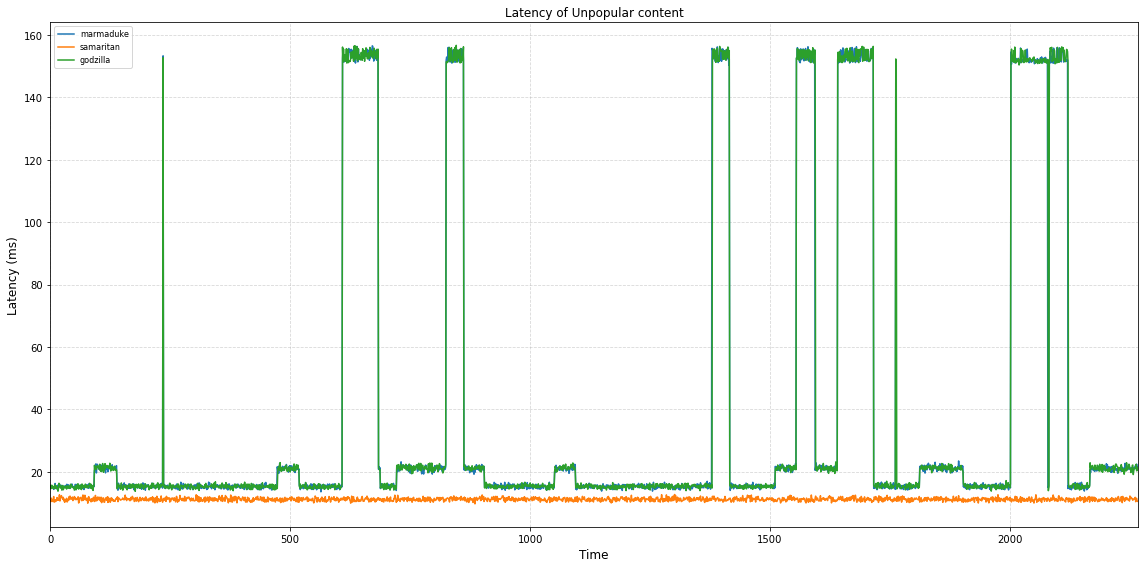

In [224]:
### LATENCY PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values_raw = get_all_column_values("latency(ms)")
all_column_values = {}
print("*** Avg latency ***")
for i, column_values in all_column_values_raw.items():
    column_values_float = []
    column_values_float_for_avg = []
    for value in column_values:
        if value == ' ':
            value = 0
            column_values_float.append(value_rounded) 
            continue # avoids adding 0 for calculating average
        value_rounded = round(float(value),2)
        column_values_float.append(value_rounded)
        column_values_float_for_avg.append(value_rounded)
        
    all_column_values[i] = column_values_float
    mean = round(np.mean(column_values_float_for_avg),2)
    confidence_interval = [round(val, 2) for val in stats.t.interval(0.90, len(column_values_float_for_avg) - 1, loc=mean, scale=stats.sem(column_values_float_for_avg))]
    print(i.split("_")[0],":\t", mean, "ms\t", " 90% CI:",confidence_interval)
    

### For Popular

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
for filename, column_values in all_column_values.items():
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename or "myimage" in filename:
        name = filename.split("_")[0]
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Latency (ms)', fontsize=12)

# Set the title of the plot
ax.set_title('Latency of Popular content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()



### For UnPopular

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
for filename, column_values in all_column_values.items():
    # ignore since they used IPv6
    #if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename:
    if "godzilla" in filename or "marmaduke" in filename or "samaritan" in filename:
        name = filename.split("_")[0]
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Latency (ms)', fontsize=12)

# Set the title of the plot
ax.set_title('Latency of Unpopular content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

*** Avg Hop Counts ***
marmaduke :	 21.1
citadel :	 17.0
ringsofpower :	 17.0
samaritan :	 9.0
myimage :	 17.43
myvideo :	 17.0
godzilla :	 21.11
harlem :	 21.11


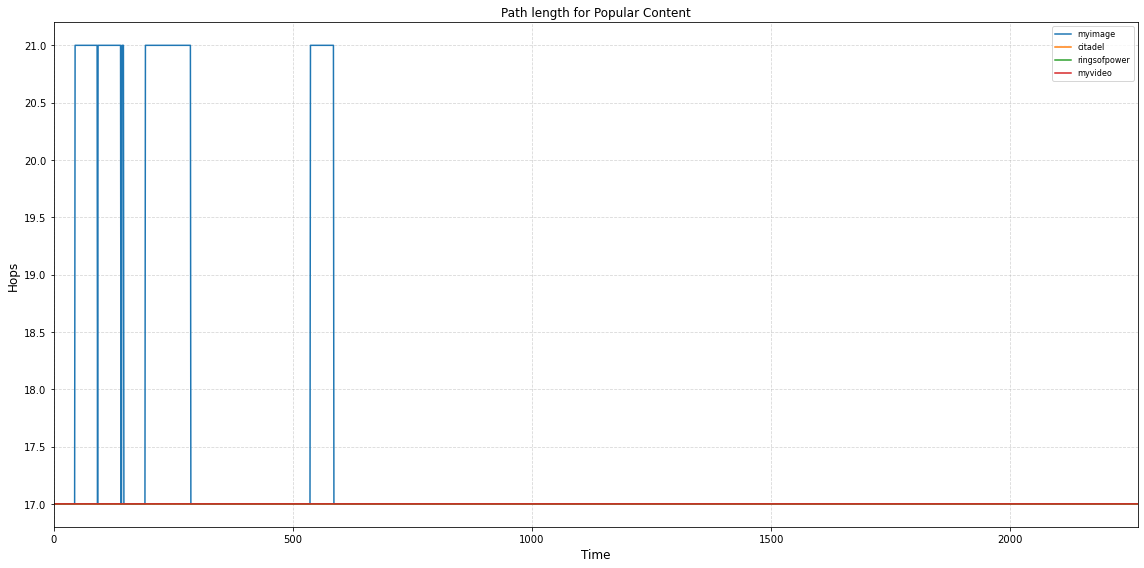

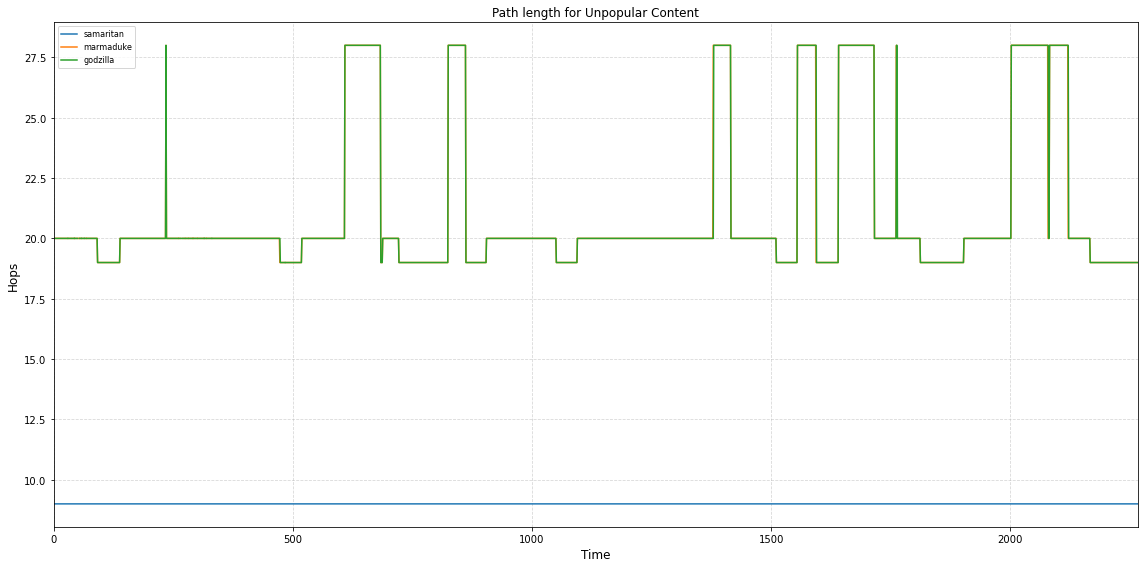

In [225]:
### HOPCOUNT PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


all_column_values = {}

# for samaritan (IPv6) we use do reverse dns of ipv6 then look up hostname for ipv4 then took traceroute 
# and hop count from last week data instead
all_column_values_raw = get_all_column_values("responseIP")
for i, column_values in all_column_values_raw.items():
    if "samaritan" in i:
        column_values_int = [9 if value == "2a02:3d0:d:12:207:43ff:fe43:f0e0" else None for value in column_values]
        all_column_values[i] = column_values_int
        break

# for myimage (IPv6) we use looked up Am-Cf-Pop and then mapped it to traceroute from last week's data
all_column_values_raw = get_all_column_values("X-Amz-Cf-Pop")
for i, column_values in all_column_values_raw.items():
    if "myimage" in i:
        column_values_int = [17 if value == "ZRH55-P1" else (21 if value == "MXP63-P2" else None) for value in column_values]
        all_column_values[i] = column_values_int
        break

all_column_values_raw = get_all_column_values("hop count")
print("*** Avg Hop Counts ***")
for i, column_values in all_column_values_raw.items():
    if "myimage" in i or "samaritan" in i:
        column_values = all_column_values[i]
        column_values_int_for_avg = all_column_values[i]
    column_values_int_for_avg = [int(value) for value in column_values if value != ' '] # ignore 0s for average
    column_values_int = [int(value) if value != " " else None for value in column_values] # maps '' to 0
    all_column_values[i] = column_values_int
    mean = round(np.mean(column_values_int_for_avg),2)
    confidence_interval = [round(val, 1) for val in stats.t.interval(0.90, len(column_values_int_for_avg) - 1, loc=mean, scale=stats.sem(column_values_int_for_avg))]
    print(i.split("_")[0],":\t", mean)

    
### For Popular

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
for filename, column_values in all_column_values.items():
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename or "myimage" in filename:
        name = filename.split("_")[0]
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Path length for Popular Content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()



### For UnPopular

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
for filename, column_values in all_column_values.items():
    # ignore since they used IPv6
    #if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename:
    if "godzilla" in filename or "marmaduke" in filename or "samaritan" in filename:
        name = filename.split("_")[0]
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Path length for Unpopular Content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

*** Cache hit/miss ***


marmaduke:
	- Miss from cloudfront: 99.43%
	- Empty: 0.57%


citadel:
	- Miss from cloudfront: 100.0%


ringsofpower:
	- Hit from cloudfront: 100.0%


samaritan:
	- Empty: 100.0%


myimage:
	- Hit from cloudfront: 100.0%


myvideo:
	- Hit from cloudfront: 100.0%


godzilla:
	- Miss from cloudfront: 99.51%
	- Empty: 0.49%


harlem:
	- Hit from cloudfront: 57.34%
	- Miss from cloudfront: 41.91%
	- Empty: 0.75%


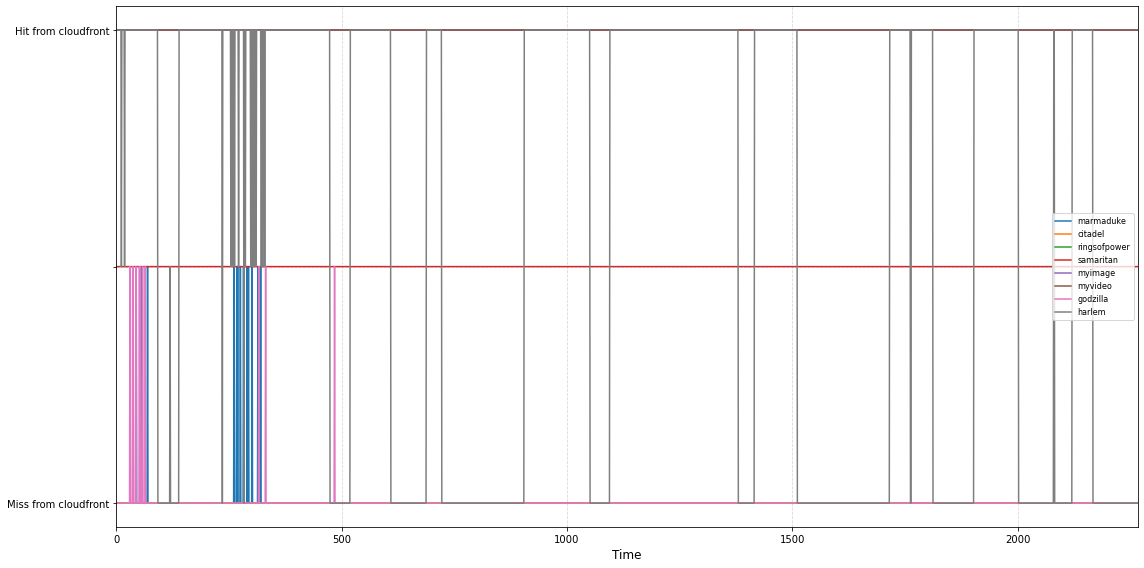

In [227]:
### X-Cache Hit PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import Counter

def calculate_percentage_distribution(lst):
    counter = Counter(lst)
    total_count = len(lst)
    distribution = {}

    for value, count in counter.items():
        percentage = (count / total_count) * 100
        distribution[value] = round(percentage,2)

    sorted_distribution = dict(sorted(distribution.items(), key=lambda x: x[1], reverse=True))
    return sorted_distribution

print("*** Cache hit/miss ***")
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    print(f"\n\n{name}:")
    distribution = calculate_percentage_distribution(column_values)
    for value, percentage in distribution.items():
        if value == ' ':
            value = "Empty"
        print(f"\t- {value}: {percentage}%")

all_column_values = get_all_column_values("X-Cache")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

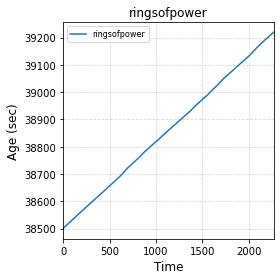

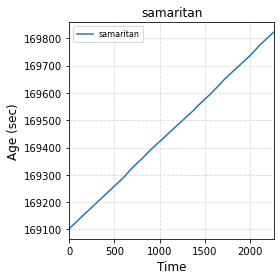

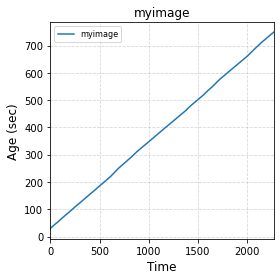

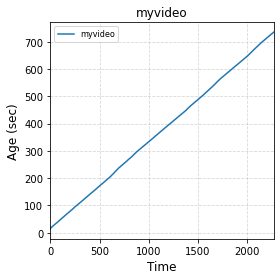

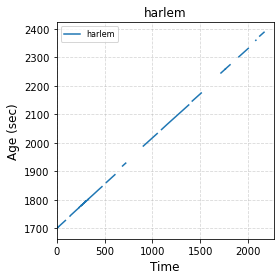

In [191]:
### AGE PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values_raw = get_all_column_values("Age")
all_column_values = {}

for i, column_values in all_column_values_raw.items():
    # ignore since their Age columns is always empty
    if "marmaduke" in i or "citadel" in i or "godzilla" in i:
        continue
    column_values_int = [int(value)/60 if value != " " else None for value in column_values] # maps '' to None 
    all_column_values[i] = column_values_int

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    plt.plot(time[:len(column_values)], column_values, label=name)

    # Set the x-axis and y-axis labels
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Age (sec)', fontsize=12)

    # Set the title of the plot
    plt.title(name)

    # Add a legend with a white background and increased font size
    plt.legend(facecolor='white', fontsize=8)

    # Adjust the figure size and spacing between subplots
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()

    # Adjust the limits of the x-axis and y-axis to remove excess space
    plt.xlim(0, max_time - 1)

    # Add gridlines for better readability
    plt.grid(True, linestyle='--', alpha=0.5)

    # Display the plot
    plt.show()

In [264]:
import geoip2.database
import json
 

def ip_to_location(ip_address):
    # Load the GeoIP2 database
    reader = geoip2.database.Reader('GeoLite2-City.mmdb')
    
    try:
        # Perform the IP lookup
        response = reader.city(ip_address)

        # Get the city name
        city_name = response.city.name
        country_name = response.country.name
    
    except Exception as e:
        return ["", ""]

    # Close the GeoIP2 reader
    reader.close()
    return [city_name, country_name]


def iata_to_location(iata_code):
    iata_code = iata_code[:3]
    # Open the JSON file
    with open('/Users/abdullah/Documents/PrimeVideo/PrimeVideo Scripts/cloudfront-edge-locations.json', 'r') as file:
        # Load the JSON data into a dictionary
        data = json.load(file)
    
    iata_to_location = {}
    for iata, info in data["nodes"].items():
        country = info["country"]
        city = info["city"]
        airport = info["airport"]
        iata_to_location[iata] = [city, country, airport]
        #print(iata, city)
    
    if iata_code in iata_to_location:
        return iata_to_location[iata_code]
    else:
        return ["","",""]


if __name__ == '__main__':
    # testing
    ip_address = '54.182.188.113'
    location = ip_to_location(ip_address)
    print(f"{ip_address} is mapped to {location}")

    iata_code = "BNE50-P2"
    location = iata_to_location(iata_code)
    print(f"{iata_code} is mapped to {location[:2]}") # print only city and country

54.182.188.113 is mapped to [None, 'United States']
BNE50-P2 is mapped to ['Brisbane', 'Australia']


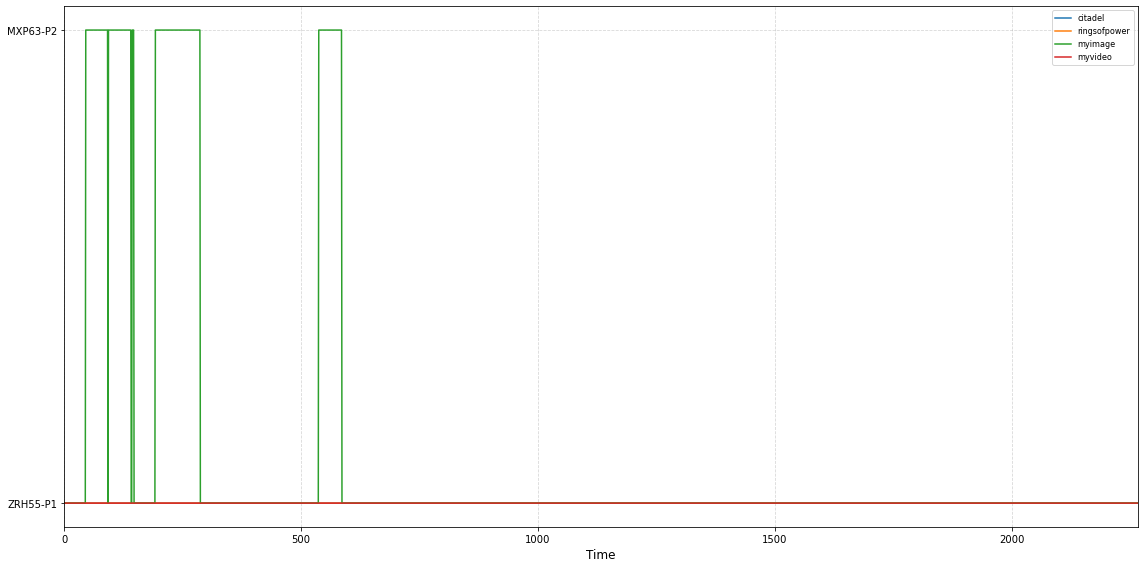

FRA51-M1 = Frankfurt Germany
FRA52-M2 = Frankfurt Germany
FRA54-M3 = Frankfurt Germany
LHR50-M1 = London United Kingdom
LHR61-M2 = London United Kingdom
LHR62-M3 = London United Kingdom
MXP63-P2 = Milan Italy
SFO20-M2 = San Francisco, CA United States
SFO5-M1 = San Francisco, CA United States
SFO50-M3 = San Francisco, CA United States
ZRH55-P1 = Zürich Switzerland


In [194]:
### CloudFront Edge Locations PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Amz-Cf-Pop")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename or "myimage" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

all_values = [item for sublist in all_column_values.values() for item in sublist]
all_codes = list(set(all_values))
all_codes.sort()

for code in all_codes:
    if len(code)>3:
        location = iata_to_location(code)
        print(code,"=", location[0], location[1])

# format = IATACode<DatacenterCode>-Cluster<ClusterNumber> (I assumed)
# e.g, ZRH55-P1
# It is not possible to determine the exact meaning without access to Amazon's internal documentation.

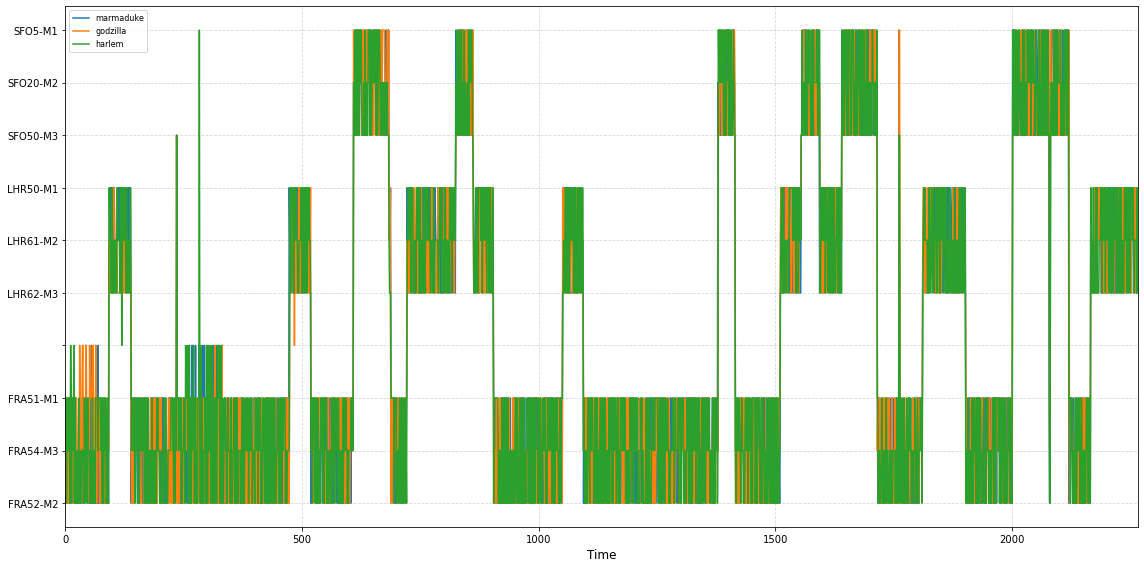

FRA51-M1 = Frankfurt Germany
FRA52-M2 = Frankfurt Germany
FRA54-M3 = Frankfurt Germany
LHR50-M1 = London United Kingdom
LHR61-M2 = London United Kingdom
LHR62-M3 = London United Kingdom
MXP63-P2 = Milan Italy
SFO20-M2 = San Francisco, CA United States
SFO5-M1 = San Francisco, CA United States
SFO50-M3 = San Francisco, CA United States
ZRH55-P1 = Zürich Switzerland


In [192]:
### CloudFront Edge Locations (UNpopular content) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Amz-Cf-Pop")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "godzilla" in filename or "marmaduke" in filename or "harlem" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

all_values = [item for sublist in all_column_values.values() for item in sublist]
all_codes = list(set(all_values))
all_codes.sort()

for code in all_codes:
    if len(code)>3:
        location = iata_to_location(code)
        print(code,"=", location[0], location[1])

# format = IATACode<DatacenterCode>-Cluster<ClusterNumber> (I assumed)
# e.g, ZRH55-P1
# It is not possible to determine the exact meaning without access to Amazon's internal documentation.

In [102]:
### CloudFront Edge Locations PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import Counter

def calculate_percentage_distribution(lst):
    counter = Counter(lst)
    total_count = len(lst)
    distribution = {}

    for value, count in counter.items():
        percentage = (count / total_count) * 100
        distribution[value] = round(percentage,2)

    sorted_distribution = dict(sorted(distribution.items(), key=lambda x: x[1], reverse=True))
    return sorted_distribution

print("***** Distribution *****")

all_column_values = get_all_column_values("X-Amz-Cf-Pop")
for filename, column_values in all_column_values.items():
    distribution = calculate_percentage_distribution(column_values)
    name = filename.split("_")[0]
    print(f"\n{name}:")
    for value, percentage in distribution.items():
        if value == ' ':
            value = "empty"
        print(f"\t- {value}: {percentage}%")

***** Distribution *****

marmaduke:
	- FRA52-M2: 19.63%
	- FRA51-M1: 19.23%
	- FRA54-M3: 18.66%
	- LHR61-M2: 8.56%
	- LHR50-M1: 8.47%
	- LHR62-M3: 8.07%
	- SFO50-M3: 6.35%
	- SFO5-M1: 5.6%
	- SFO20-M2: 4.85%
	- empty: 0.57%

citadel:
	- ZRH55-P1: 100.0%

ringsofpower:
	- ZRH55-P1: 100.0%

samaritan:
	- empty: 100.0%

myimage:
	- ZRH55-P1: 89.28%
	- MXP63-P2: 10.72%

myvideo:
	- ZRH55-P1: 100.0%

godzilla:
	- FRA52-M2: 19.72%
	- FRA51-M1: 19.5%
	- FRA54-M3: 18.39%
	- LHR62-M3: 8.69%
	- LHR61-M2: 8.38%
	- LHR50-M1: 7.9%
	- SFO50-M3: 6.09%
	- SFO5-M1: 5.78%
	- SFO20-M2: 5.07%
	- empty: 0.49%

harlem:
	- FRA51-M1: 19.81%
	- FRA52-M2: 18.92%
	- FRA54-M3: 18.61%
	- LHR61-M2: 8.87%
	- LHR50-M1: 8.51%
	- LHR62-M3: 7.59%
	- SFO50-M3: 6.26%
	- SFO20-M2: 5.43%
	- SFO5-M1: 5.25%
	- empty: 0.75%


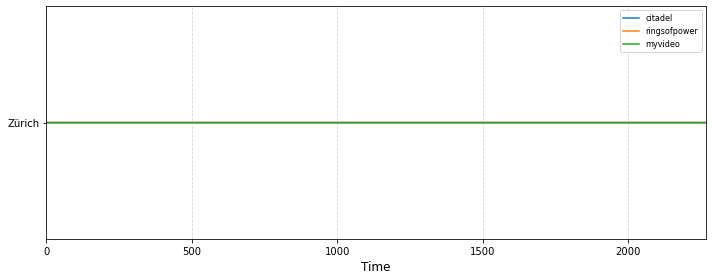

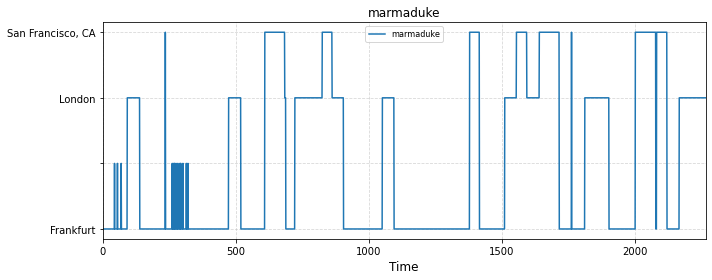

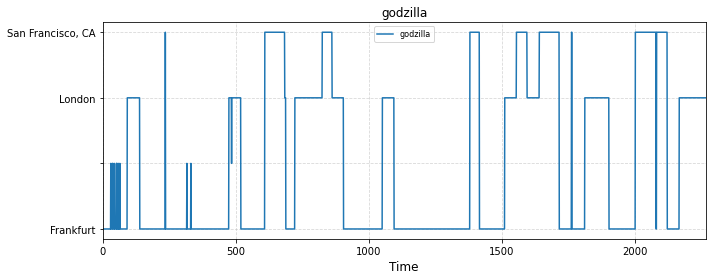

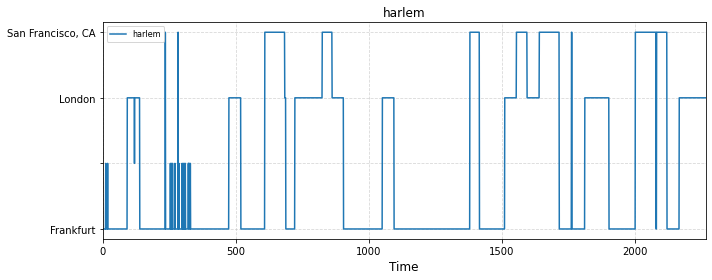

In [229]:
### City of X-Amz-Cf-Pop (IATA Mapping) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


all_column_values_raw = get_all_column_values("X-Amz-Cf-Pop")
all_column_values = {}
# convert IATA to location
for i, column_values in all_column_values_raw.items():
    column_values_int = [iata_to_location(iata)[0] for iata in column_values]
    all_column_values[i] = column_values_int
    

# for Samaritan we use responseIP instead
all_column_values_raw = get_all_column_values("responseIP")
for i, column_values in all_column_values_raw.items():
    if "samaritan" in i:
        column_values_int = [ip_to_location(ip_address)[0] for ip_address in column_values]
        column_values_int = [value if value != "" else " " for value in column_values_int]
        all_column_values[i] = column_values_int
        break
    
### Popular content

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(10, 4)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()



### Unpopular content

all_column_values_raw = get_all_column_values("X-Amz-Cf-Pop")
all_column_values = {}
# convert IATA to location
for i, column_values in all_column_values_raw.items():
    column_values_int = [iata_to_location(iata)[0] for iata in column_values]
    #column_values_int = [value if value != "" else None for value in column_values_int]
    all_column_values[i] = column_values_int
    

# for Samaritan we use responseIP instead
all_column_values_raw = get_all_column_values("responseIP")
for i, column_values in all_column_values_raw.items():
    if "samaritan" in i:
        column_values_int = [ip_to_location(ip_address)[0] for ip_address in column_values]
        column_values_int = [value if value != "" else " " for value in column_values_int]
        all_column_values[i] = column_values_int
        break

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "godzilla" in filename or "marmaduke" in filename or "harlem" in filename:
        plt.plot(time[:len(column_values)], column_values, label=name)

        # Set the x-axis and y-axis labels
        plt.xlabel('Time', fontsize=12)
        #plt.ylabel('Age (sec)', fontsize=12)

        # Set the title of the plot
        plt.title(name)

        # Add a legend with a white background and increased font size
        plt.legend(facecolor='white', fontsize=8)
        
        # Adjust the figure size and spacing between subplots
        plt.gcf().set_size_inches(10, 4)
        plt.tight_layout()

        # Adjust the limits of the x-axis and y-axis to remove excess space
        plt.xlim(0, max_time - 1)

        # Add gridlines for better readability
        plt.grid(True, linestyle='--', alpha=0.5)

        # Display the plot
        plt.show()

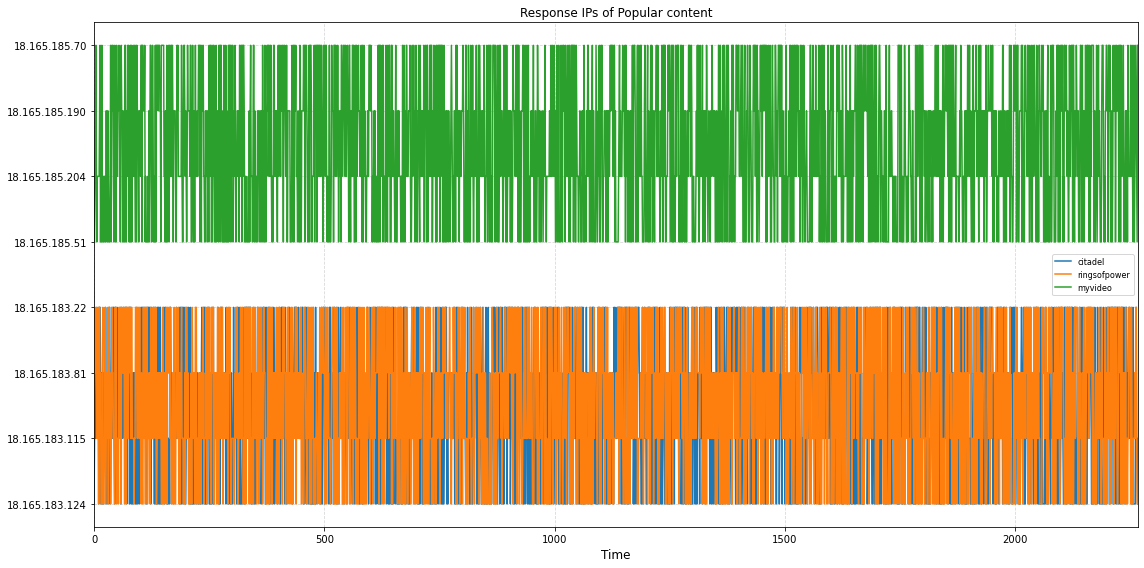

In [240]:
### Server IPs (Popular & My content) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "citadel" in filename or "myvideo" in filename or "ringsofpower" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Response IPs of Popular content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

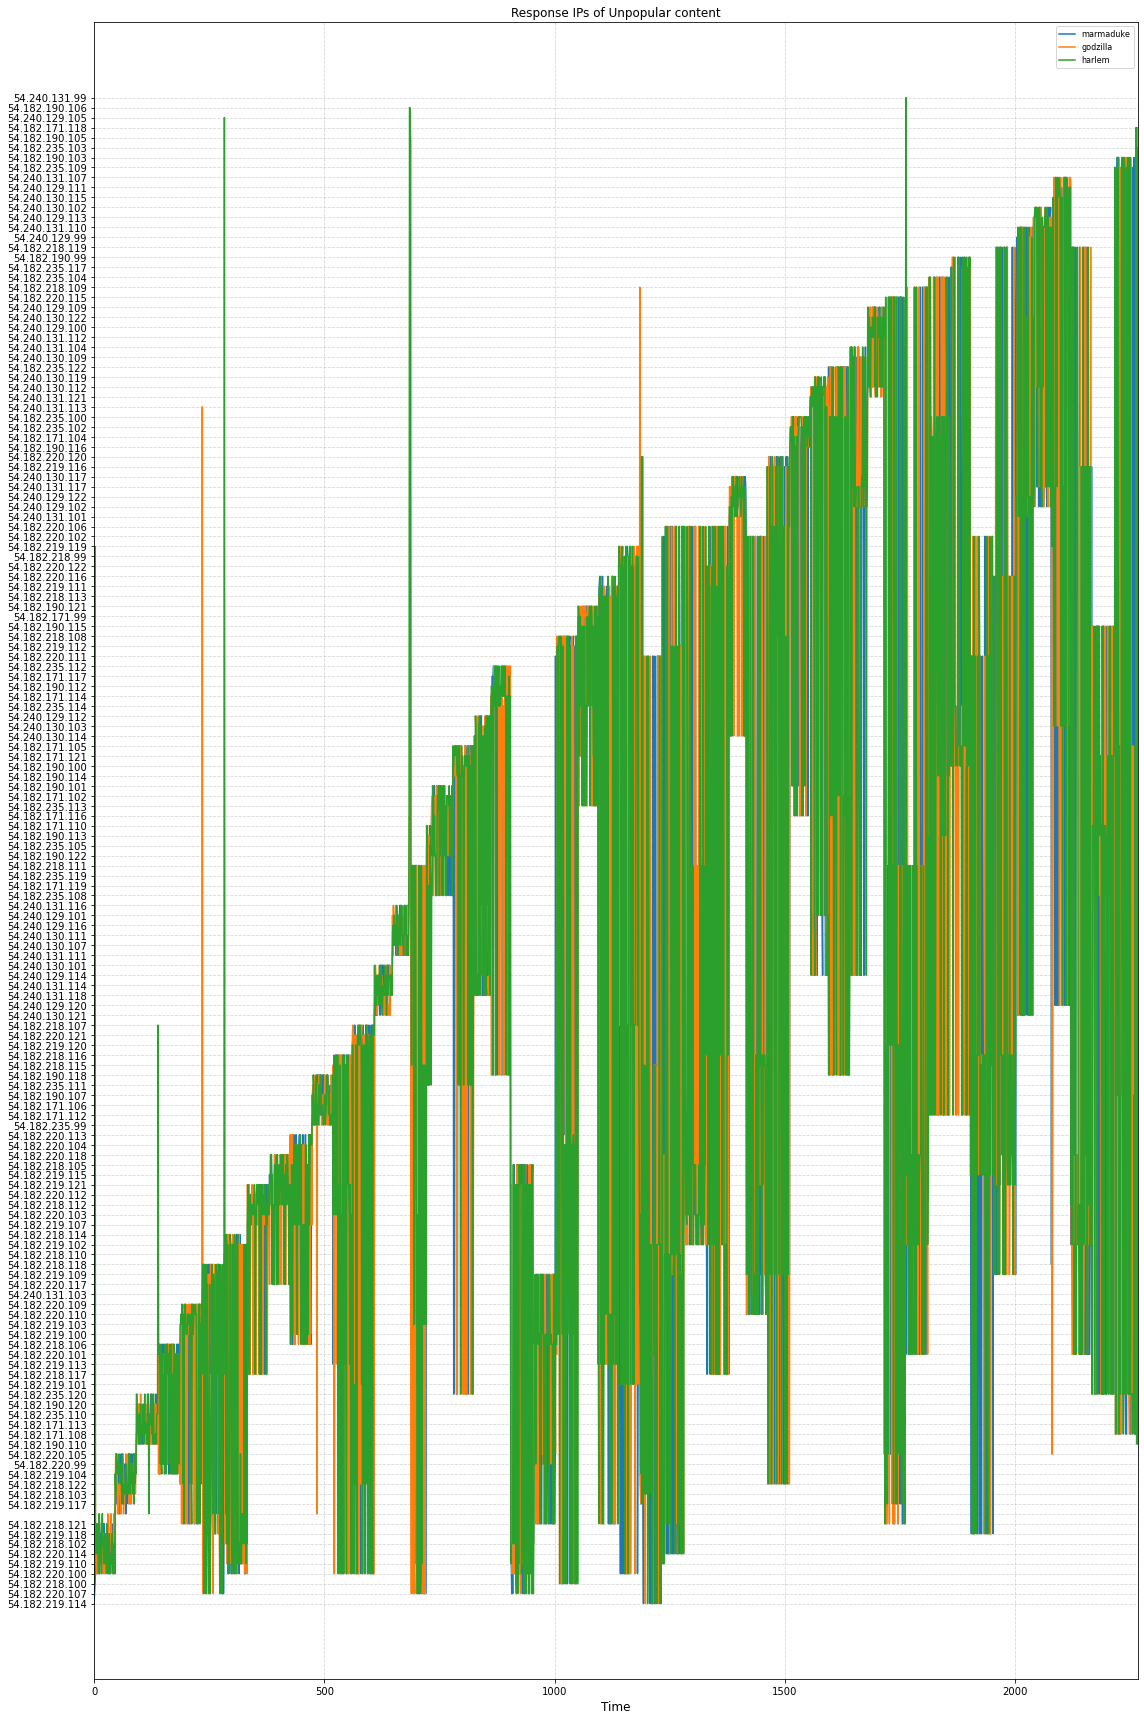

In [239]:
### Server IPs (Not popular) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "harlem" in filename or "godzilla" in filename or "marmaduke" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Response IPs of Unpopular content')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 24)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

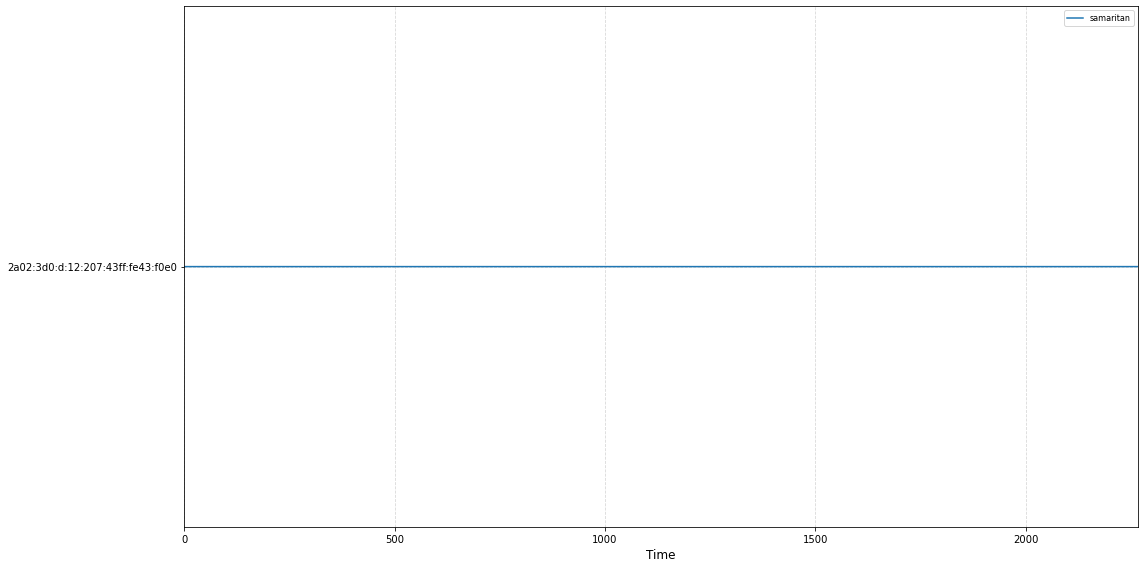

In [230]:
### Server IPs (Samaritan) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "samaritan" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

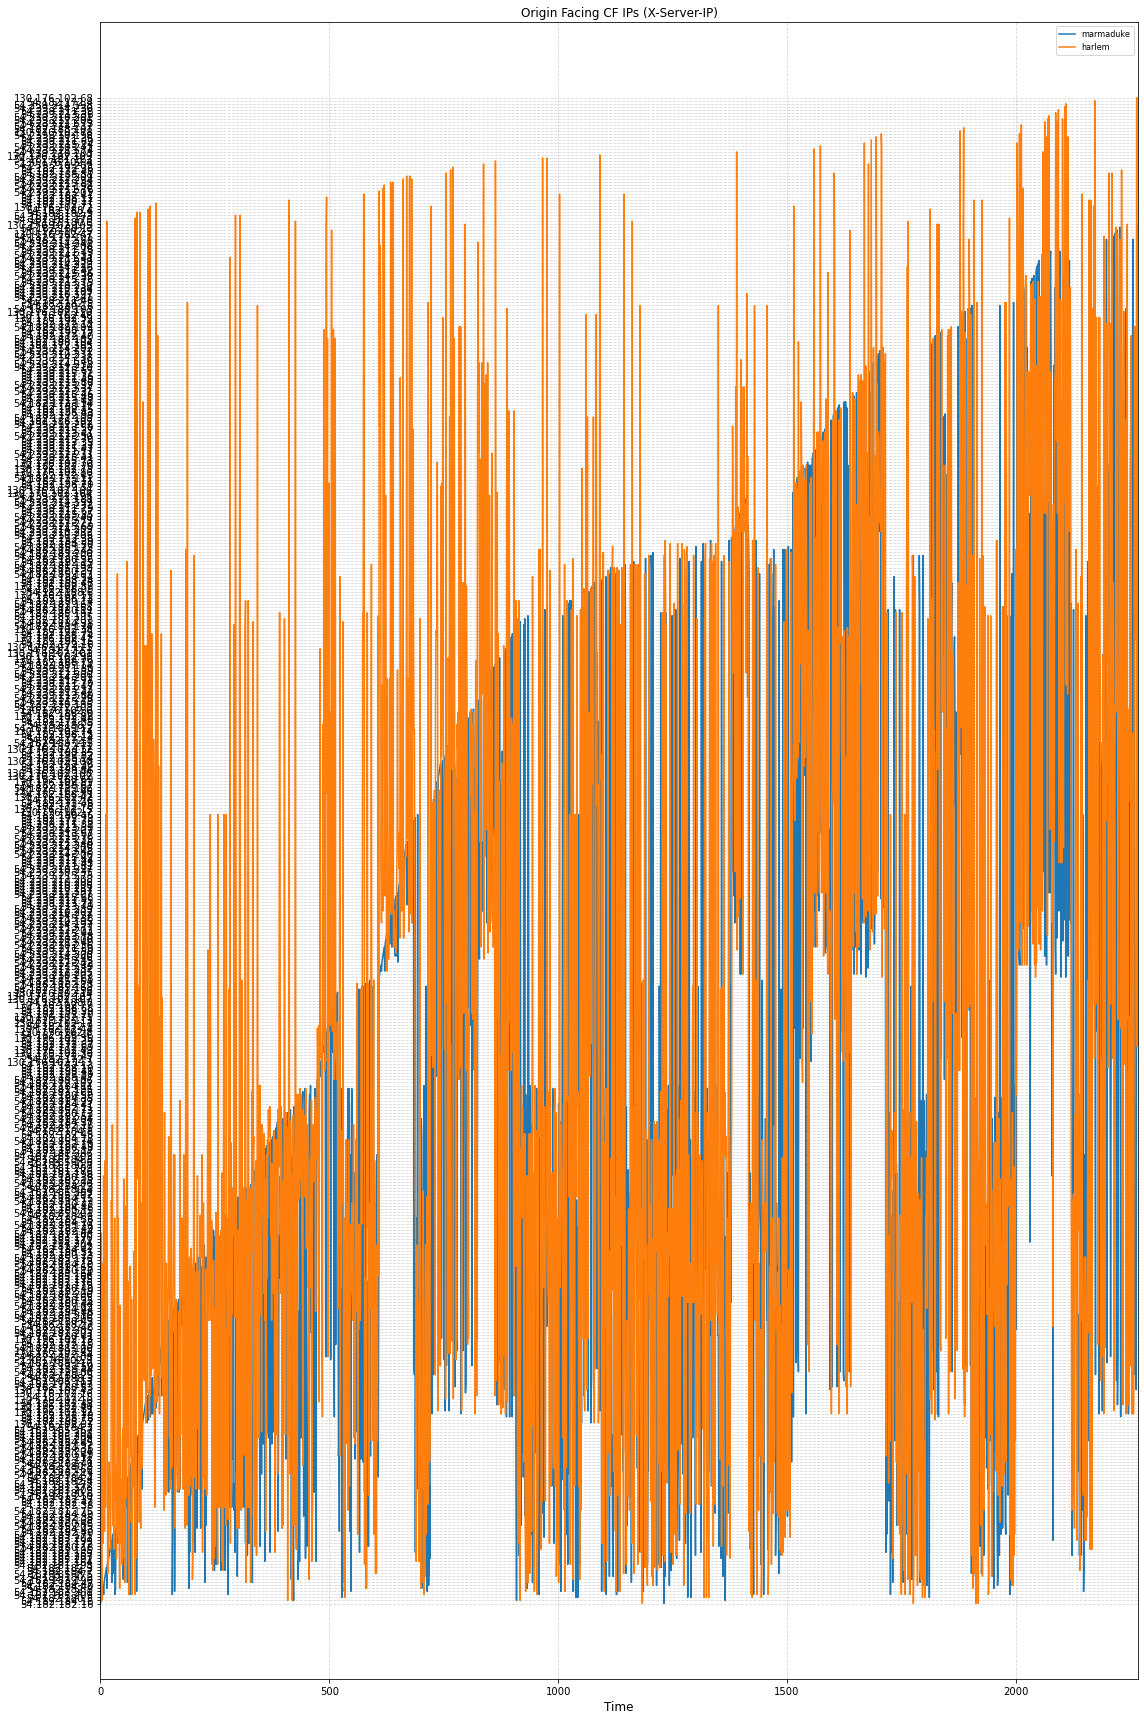

In [254]:
### X-Server-IP (Popular & My content) PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Server-IP")

# Define the time series for the x-axis
max_time = max( len(values) for values in all_column_values.values() )
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values for each website response
for filename, column_values in all_column_values.items():
    name = filename.split("_")[0]
    if "harlem" in filename or "marmaduke" in filename:
        ax.plot(time[:len(column_values)], column_values, label=name)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
ax.set_title('Origin Facing CF IPs (X-Server-IP)')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 24)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

In [ ]:
import pandas as pd

# Read the data from the CSV file
df = pd.read_csv('your_file.csv')

# Filter the rows with x-cache = hit
filtered_df = df[df['x-cache'] == 'hit']

# Retrieve the latencies in a row
latencies = filtered_df['latency'].tolist()

print(latencies)

In [266]:
for file_name in os.listdir(RESULT_PATH):
    if file_name.endswith('.csv'):
        print(file_name)
        file_path = os.path.join(RESULT_PATH, file_name)
        df = pd.read_csv(file_path)
        
        # Filter the rows with x-cache = hit or miss
        filtered_df1 = df[df['X-Cache'] == 'Miss from cloudfront']
        latencies_miss = filtered_df1['latency(ms)'].tolist()
        latencies_miss = pd.to_numeric(latencies_miss, errors='coerce')
        
        filtered_df2 = df[df['X-Cache'] == 'Hit from cloudfront']
        latencies_hit = filtered_df2['latency(ms)'].tolist()
        latencies_hit = pd.to_numeric(latencies_hit, errors='coerce')
        
        print("Miss: ",round(np.mean(latencies_miss),2),"ms")
        print("Hit: ",round(np.mean(latencies_hit),2), "ms")
        print("\n\n")

marmaduke_08-06-2023_04hh_56mm.csv
Miss:  40.04 ms
Hit:  nan ms



citadel_08-06-2023_04hh_56mm.csv
Miss:  5.86 ms
Hit:  nan ms



ringsofpower_08-06-2023_04hh_56mm.csv
Miss:  nan ms
Hit:  5.84 ms



samaritan_08-06-2023_04hh_56mm.csv


/Users/abdullah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abdullah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Miss:  nan ms
Hit:  nan ms



myimage_08-06-2023_04hh_56mm.csv
Miss:  nan ms
Hit:  8.36 ms



myvideo_08-06-2023_04hh_56mm.csv
Miss:  nan ms
Hit:  5.86 ms



godzilla_08-06-2023_04hh_56mm.csv
Miss:  40.25 ms
Hit:  nan ms



harlem_08-06-2023_04hh_56mm.csv
Miss:  74.5 ms
Hit:  15.31 ms



